# Giacomo Menegatti Homework 6

## WARNING
This homework is not completed becuase I haven't been able to reproduce the wanted results. I submit this as a proof of my work, and I will try to fix the bugs and errors present in the code in the next few days.

## LAGEOS satellite orbit propagation
For this work I found a different library than pysofa which is pyerfa (Essential Routines for Fundamental Astronomy) based on SOFA, which I found more complete.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import erfa
import matplotlib.pyplot as plt


### Associated Legendre Functions table of coefficients
The coefficients are calculated by the relations $$f_n = \sqrt{(1+\delta_{1n})\frac{2n+1}{2n}} $$
$$ g^m_n =\sqrt{\frac{(2n+1)(2n-1)}{(n+m)(n-m)}} $$
$$ h_n^m = \frac{g_n^m}{g^m_{n-1}} $$
$$ f'_n=\sqrt{\frac{n(n+1)}{2}} $$
$$ k_n^m = \frac{1}{2}\sqrt{(n-m)(n+m+1)} $$
$$ l_n^m = \frac{1}{2}\sqrt{(1+\delta_{1m})(n+m)(n-m+1)} $$ 

The Legendre functions are calculated with the recurrent relationships

$$ P_n^n(\sin \phi) = f_n \cos \phi P^{n-1}_{n-1}(\sin \phi) $$
$$ P_n^{n-1}(\sin \phi) = g_n^m \sin \phi P^{n-1}_{n-1}(\sin \phi) $$
$$ P_n^m(\sin \phi) = g_n^m \sin \phi P^{m}_{n-1}(\sin \phi) - h^m_n P^{m}_{n-2}(\sin \phi)$$
$$ \partial_\phi P_n(\sin \phi) = f'_n P_n^1(\sin \phi) $$
$$ \partial_\phi P_n^m(\sin \phi) = k_n^m P_n^{m+1}(\sin \phi)-l_n^m P_n^{m-1}(\sin \phi) $$

The functions and the coefficients are saved in a table where the index is given by $\frac{n(n+1)}{2}+m$. In this way each value for $n$, $0\leq m\leq n$ is assigned to a unique entry. I assume that all values with $m>n$ are equal to zero. 


In [2]:
f = lambda n, m : ((1+1*(n==1))*(2*n+1)/(2*n))**0.5 #I added the m variable even as I don't use it to have the same form
g = lambda n, m : ((2*n+1)*(2*n-1)/((n+m)*(n-m)))**0.5
h = lambda n, m : g(n,m)/g(n-1,m)

fprime = lambda n, m : (n*(n+1)/2)**0.5
k = lambda n, m : 0.5*((n-m)*(n+m+1))**0.5
l = lambda n, m : 0.5*((1+1*(m==1))*(n+m)*(n-m+1))**0.5

#Index function
i = lambda n,m : n*(n+1)//2+m

#Table of coefficients. Values that do not exists are reported as Nan
#In this way the indexing of the values is always the same

def coef_table(deg):
  M_ = [m for n in range(deg+1) for m in range(n+1)]
  N_ = [n for n in range(deg+1) for m in range(n+1)]

  F_ = [f(n,m) if n>0 else np.NAN for m, n in zip(M_,N_)]
  G_ = [g(n,m) if n>m else np.NAN for m,n in zip(M_,N_)] #g is not defined for m==n
  H_ = [h(n,m) if n>m+1 else np.NAN for m,n in zip(M_,N_)] #g is not defined for m==n and m=n-1
  FPRIME_ = [fprime(n,m) for m, n in zip(M_,N_)]
  K_ = [k(n,m) for m, n in zip(M_,N_)]
  L_ = [l(n,m) for m, n in zip(M_,N_)]
  
  return M_,N_,F_,G_,H_,FPRIME_,K_,L_


In [3]:
M_coeff,N_coeff,F_coeff,G_coeff,H_coeff,FPRIME_coeff,K_coeff,L_coeff = coef_table(10)
table = pd.DataFrame(np.array([M_coeff,N_coeff,F_coeff,G_coeff,H_coeff,FPRIME_coeff,K_coeff,L_coeff]).transpose(), columns=['n','m','f','g','h','fprime','k','l'])
table.head(10)


,n,m,f,g,h,fprime,k,l
0,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,0.0,1.0,1.732051,1.732051,NaN,1.000000,0.707107,0.707107
2,1.0,1.0,1.732051,NaN,NaN,1.000000,0.000000,1.000000
3,0.0,2.0,1.118034,1.936492,1.118034,1.732051,1.224745,1.224745
4,1.0,2.0,1.118034,2.236068,NaN,1.732051,1.000000,1.732051
5,2.0,2.0,1.118034,NaN,NaN,1.732051,0.000000,1.000000
6,0.0,3.0,1.080123,1.972027,1.018350,2.449490,1.732051,1.732051
7,1.0,3.0,1.080123,2.091650,0.935414,2.449490,1.581139,2.449490
8,2.0,3.0,1.080123,2.645751,NaN,2.449490,1.224745,1.581139
9,3.0,3.0,1.080123,NaN,NaN,2.449490,0.000000,1.224745


The coeeficients are the same ones given in the provided table.

In [4]:
def ALF_table(x, deg=10):
  # The index of (n,m) is n^2+n+1-m

  P_ = [1.0]  #P(0,0)
  DP_ = [0.0]

  for n in range(1,deg+1):
    for m in range(n+1):

      if m==n:
        P_.append(F_coeff[i(n,m)]*(1-x**2)**0.5 * P_[i(n-1, n-1)])   #As x is sin, cos is sqrt(1-x^2)
      elif m==n-1:
        P_.append(G_coeff[i(n,m)]*x*P_[i(n-1, n-1)])
      else:
        P_.append(G_coeff[i(n,m)]*x*P_[i(n-1, m)]-H_coeff[i(n,m)]*P_[i(n-2, m)])

  for n in range(1,deg+1):
    for m in range(0, n+1):
      
      if m==0:
        DP_.append(fprime(n,m)*P_[i(n,1)])
      elif m==n:  # In this condition the first value is zero
        DP_.append(-L_coeff[i(n,m)]*P_[i(n,m-1)])
      else:
        DP_.append(K_coeff[i(n,m)]*P_[i(n,m+1)] - L_coeff[i(n,m)]*P_[i(n,m-1)])

  return np.array(P_),np.array(DP_)
  

### fnALF test
The fnALFs have to satisfy the conditions $$ \sum_{n=0}^N \sum_{m=0}^n P_n^m (x) = (N+1)^2 $$ $$ \sum_{n=0}^N \sum_{m=0}^n \partial_x P_n^m (x) = \frac{(N+1)^2(N+2)N}{4} $$ for every angle. This has been proven up to N=10 selecting every time a random angle.

In [5]:
for deg in range(11):
  phi = np.random.uniform(-np.pi/2, np.pi/2)  #Get a random angle every time
  P, DP = ALF_table(np.sin(phi), deg)
  print(f'For N={deg}: expected values {(deg+1)**2} and {(deg+1)**2*(deg+2)*deg/4}: obtained {sum(P**2)} and {sum(DP**2)}')


For N=0: expected values 1 and 0.0: obtained 1.0 and 0.0
For N=1: expected values 4 and 3.0: obtained 3.9999999999999996 and 2.9999999999999996
For N=2: expected values 9 and 18.0: obtained 9.0 and 17.999999999999996
For N=3: expected values 16 and 60.0: obtained 15.999999999999998 and 59.999999999999964
For N=4: expected values 25 and 150.0: obtained 25.00000000000001 and 150.00000000000003
For N=5: expected values 36 and 315.0: obtained 36.00000000000001 and 315.0000000000003
For N=6: expected values 49 and 588.0: obtained 49.000000000000014 and 588.0000000000001
For N=7: expected values 64 and 1008.0: obtained 64.0 and 1008.0
For N=8: expected values 81 and 1620.0: obtained 81.0 and 1619.9999999999998
For N=9: expected values 100 and 2475.0: obtained 100.00000000000004 and 2475.0000000000005
For N=10: expected values 121 and 3630.0: obtained 120.99999999999999 and 3630.0000000000005


### Acceleration in the body-fixed RF
The acceleration in cartesian coordinates in the body-fixed RF is given by 
$$ a_x = \cos \phi \cos \lambda \partial_r U -\frac{1}{r}\sin \phi \cos \lambda \partial_\phi U -\frac{1}{r}\frac{\sin \lambda}{\cos \phi } \partial_\lambda U $$
$$ a_y = \cos \phi \sin \lambda \partial_r U -\frac{1}{r}\sin \phi \sin \lambda \partial_\phi U + \frac{1}{r}\frac{\sin \lambda}{\cos \phi } \partial_\lambda U $$
$$ a_z = \sin \phi \partial_r U + \frac{1}{r}\cos \phi \partial_\phi U $$

The gradient of the potential is given by
$$\frac{1}{\cos \phi}\partial_\lambda U = \frac{GM}{r}\sum_{n=1}^\infty \sum_{m=1}^n \left( \frac{a_e}{r} \right)^n K_{nm}m[r_{nm}P_{n-1}^{m+1}(\sin \phi)+s_{nm}P^{m-1}_{n-1}(\sin \phi)] $$

$$ \partial_r U = -\frac{GM}{r^2}[1+\sum_{n=1}^\infty \sum_{m=0}^n (n+1)\left( \frac{a_e}{r} \right)^n H_{nm} P_{n}^{m}(\sin \phi)] $$

$$ \partial_\phi U = \frac{GM}{r}\sum_{n=1}^\infty \sum_{m=0}^n \left( \frac{a_e}{r} \right)^n H_{nm} \partial_\phi P_{n}^{m}(\sin \phi) $$

with 
$$ H_{nm} = C_{nm}\cos m\lambda + S_{nm}\sin m\lambda $$
$$ K_{nm} = S_{nm}\cos m\lambda - C_{nm}\sin m\lambda $$

$$ r_{nm} = \frac{1}{2}\sqrt{(n-m)(n+m+1)} $$
$$ s_{nm} = r_{nm}(n+m)(n+m-1)\sqrt{\frac{2n+1}{2n-1}} $$
All this calculations are done with the fully normalized functions.

In [6]:
H = lambda l, n,m,C,S : C[i(n,m)]*np.cos(m*l)+S[i(n,m)]*np.sin(m*l)
K = lambda l, n,m,C,S : S[i(n,m)]*np.cos(m*l)-C[i(n,m)]*np.sin(m*l)
r = lambda n,m : 0.5*((n+m)*(n+m+1))**0.5
s = lambda n,m : r(n,m)*(n+m)*(n+m-1)*((2*n+1)/(2*n-1))**0.5


def acc_b(x_b, C, S, GM, a_e, deg=10):
  '''Acceleration in the body-fixed RF'''
  
  R = np.linalg.norm(x_b)
  l = np.arctan2(x_b[1],x_b[0])
  phi = np.arcsin(x_b[2]/R)
  a = a_e/R
  
  P , DP = ALF_table(np.sin(phi), 10)
  
  dUr = -GM/R**2*(1+sum([(n+1)*a**n*H(l,n,m, C, S)*P[i(n,m)] for n in range(1,deg+1) for m in range(0, n+1)]))
  dUphi = GM/R*sum([a**n*H(l,n,m,C,S)*DP[i(n,m)] for n in range(1,deg+1) for m in range(0, n+1)])
  
  #In the next computation I have a problem, as it may happen that m>n
  # when computing P_{n-1}^{m+1} if m>n-2. If m=n P_{n-1}^{n+1} r_nm goes to zero, in the other case I assumed P_{n-1}^{n} to be always zero. Still I have to add a conditional statement to be sure that the computation will not happen

  dUl = GM/R*sum([ a**n*K(l,n,m,C,S)*m*s(n,m)*P[i(n-1, m-1)] if m>n-2 else a**n*K(l,n,m,C,S)*m*(r(n,m)*P[i(n-1, m+1)] + s(n,m)*P[i(n-1, m-1)]) for n in range(1,deg+1) for m in range(1, n+1)])

  ax = np.cos(phi)*np.cos(l)*dUr - np.sin(phi)*np.cos(l)/R*dUphi - np.sin(l)/R*dUl
  ay = np.cos(phi)*np.sin(l)*dUr - np.sin(phi)*np.sin(l)/R*dUphi + np.cos(l)/R*dUl
  az = np.sin(phi)*dUr + np.cos(phi)/R*dUphi

  return np.array([ax, ay, az])


### Reading the coefficients C and S

In [7]:
ICGEM = pd.read_csv('EGM96.gfc', sep='\s+', skiprows=21, header=None, names=['gfc','n', 'm', 'C', 'S', 'sigmaC', 'sigmaS'])
ICGEM.head(10)


,gfc,n,m,C,S,sigmaC,sigmaS
0,gfc,0,0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,gfc,2,0,-4.841654e-04,0.000000e+00,3.561063e-11,0.000000e+00
2,gfc,2,1,-1.869876e-10,1.195280e-09,1.000000e-30,1.000000e-30
3,gfc,2,2,2.439144e-06,-1.400167e-06,5.373915e-11,5.435327e-11
4,gfc,3,0,9.572542e-07,0.000000e+00,1.809424e-11,0.000000e+00
5,gfc,3,1,2.029989e-06,2.485132e-07,1.396517e-10,1.364588e-10
6,gfc,3,2,9.046278e-07,-6.190259e-07,1.096233e-10,1.118287e-10
7,gfc,3,3,7.210727e-07,1.414356e-06,9.515628e-11,9.328509e-11
8,gfc,4,0,5.398739e-07,0.000000e+00,1.042368e-10,0.000000e+00
9,gfc,4,1,-5.363216e-07,-4.734403e-07,8.567440e-11,8.240849e-11


In [8]:
#The values for n=1 are all zero because the origin of the RF is in the center of mass
# I set them manually to zero
C = [ICGEM.iloc[0]['C'], 0.0, 0.0]
S = [ICGEM.iloc[0]['S'], 0.0, 0.0]

# Save the coefficients up to the highest required degree in the list
C.extend(ICGEM.iloc[1:i(deg,deg)-1]['C'])
S.extend(ICGEM.iloc[1:i(deg,deg)-1]['S'])

GM = 3.986004415e14  # Gravitational parameter
R_E = 6.378136300e6  # Radius of the Earth


### LAGEOS - 1 orbit propagation
The acceleration is given in body-fixed coordinated, so they must be rotated from an inertial Rf to the body-fixed one and back. This has been done as described in the given material by calculating the matrix P of precession and nutation and rotating by the Earth rotation angle.

In [9]:
def acc_i(x_i, date1, date2, C, S, GM, a_e, deg=10):
  
  P = erfa.pnm06a(date1, date2)
  E = erfa.era00(date1, date2)  #Earth rotation angle at date
  R = erfa.rz(E,P)  #Final Rotation matrix
  x_b = np.dot(R, x_i)  #position in the body-fixed RF
  a_b = acc_b(x_b, C, S, GM, a_e, deg)
  return np.dot(R.T, a_b) #Rotating back the vector to the inertial RF


The ODE is integrated using the solve_ivp method. Because dtf2d splits the Julian date in integer part and remainder, I used the remainder to store the growing time and the first part to store the initial date.

In [10]:
# Solution od dy/dt = f(y,t)

def f(t,y,GM, C, S, a_e, date):
  x_i = y[0:3]
  v_i = y[3:6]
  a_i = acc_i(x_i, date, t, C, S, GM, a_e)
  return np.concatenate((v_i, a_i), axis=None)


As a test, I integrated the LAGEOS motion from Jan 1st 2020 to Mar 9th 2022, dates fro which I have the position and velocity.

In [11]:
date1, date2 = erfa.dtf2d("UTC", 2020, 1, 1, 0,0,0)
date3, date4 = erfa.dtf2d("UTC", 2022, 3, 9, 0, 0, 0)

x0 = np.array([-3925648.12725143,    4994759.41318484,  -10562295.01282353])
v0 = np.array([709.82404964822,    5180.59677349323,    2200.47213474637])

x_f = np.array([9198201.11108904,    3346470.46358190,   -7343619.83372384])
v_f = np.array([3760.29086118529,   -1216.94859686718,    4128.52516735403])

date_start = date1+date2
deltaT = date3 + date4 - date1-date2  #Difference in days between the start and end

dt = 1.0/(24*3600)*5  #Calculated every 5 seconds

y0 = np.concatenate((x0, v0), axis=None)
sol = solve_ivp(f, y0=y0, t_span=(0,deltaT), t_eval=np.arange(0,deltaT,dt), args=(GM, C,S,R_E, date_start), rtol=1e-12)


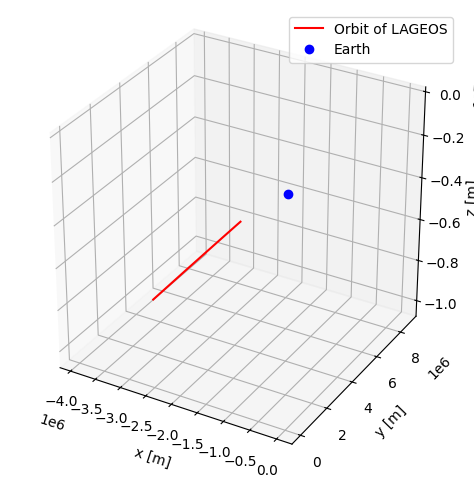

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(sol.y[0],sol.y[1], sol.y[2], color='red', label = 'Orbit of LAGEOS')

ax.plot(0,0,0, 'o', color='blue', label='Earth')
ax.set_box_aspect([1,1,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(f'The expected values are {x_f} for position and {v_f} for velocity')
print(f'The calculated values are {sol.y[0:3, -1]} for position and {sol.y[3:6, -1]} for velocity')


The expected values are [ 9198201.11108904  3346470.4635819  -7343619.83372384] for position and [ 3760.29086119 -1216.94859687  4128.52516735] for velocity
The calculated values are [-3108854.61888849  8701331.54236896 -8137348.31021642] for position and [1314.47568449 4003.04972053 3809.20999045] for velocity


The integration done in this way predicts that the satellite is not orbiting around the Earth. The reason for this mistake are not clear, as a timestep of 5 s during an orbit with period over 13000 s sould be detailed enough. It may be caused either by the integrator or the formulas, but Im' still investigating it and trying new hypothesis.

# Obtaining the initial coditions from the osculating elements
The position and velocity for Apr 20th 2022 are given by the osculating elements. 
To obtain position and velocity from those I use the Kepler's equation to obtain $E$ and then compute
$$\mathbf r = a(\cos E -e)\mathbf{\hat P} + a\sqrt{1-e^2}\sin E\mathbf{\hat Q}$$ 
$$ \mathbf{ \dot r} = -\frac{na^2}{r}\sin E \mathbf{\hat P} + \frac{na^2}{r}\sqrt{1-e^2}\cos E \mathbf{\hat Q}$$
$$ r = a(1-e\cos E) $$ 
$$\mu =n^2a^3 $$
and then I apply $$ \mathbf{r}_I =  R_z(-\Omega)R_x(-i)R_z(\pi-\Omega) \mathbf{r}_L $$ to rotate the vectors from the Lagrange RF to the geocentric

In [ ]:
def Rx(theta, v):
  '''Rotation to align to a vector along the x-axis'''
  return np.array([v[0], v[1]*np.cos(theta)+v[2]*np.sin(theta), -v[1]*np.sin(theta)+v[2]*np.cos(theta)])

def Rz(theta, v):
  '''Rotation to align to a vector around the z-axis'''
  return np.array([v[0]*np.cos(theta)+v[1]*np.sin(theta), -v[0]*np.sin(theta)+v[1]*np.cos(theta), v[2]])

def SolveKeplerEq(M,e, atol=1e-14):
  '''Solver of the Kepler's equation'''
  # This works only if M is between 0 and 2pi, so I have to rescalate it
  k = np.floor(M/(2*np.pi))
  M = M-k*2*np.pi           #Subtract all the complete orbits
  E = M
  Delta = 1e2
  while(Delta > atol):
    Delta = (E - e*np.sin(E) - M)/(1-e*np.cos(E))
    E = E - Delta
  return E

def Lagrange_coord(a, e, M, mu=GM):
  '''position and velocity in the Lagrange RF'''
  E = SolveKeplerEq(M,e)
  n = (mu*a**-3)**0.5
  r = a*(1-e*np.cos(E))

  X = np.array([a*(np.cos(E)-e), a*(1-e**2)**0.5*np.sin(E), 0]) 
  V = np.array([-n*a**2/r*np.sin(E), n*a*2/r*(1-e**2)**0.5*np.cos(E), 0])
  return X,V

def Inertial_coord(a, e, M, i, Omega, omega, mu=GM):
  X, V = Lagrange_coord(a, e, M, mu)
  x_i = Rz(-Omega, Rx( -i, Rz( omega, X )))
  v_i = Rz(-Omega, Rx( -i, Rz( omega, V )))
  return np.concatenate((x_i, v_i), axis=None)


I tested this on the LAGEOS initial conditions for Jan 1st 2020, for which I have both the cartesian and the osculating element representation. The positions seems to match but with inverted sign, while the velocities don't. I can't find a reason for this as the software is the same that has benn used in the Ephemeris homeowrk withou problems.

In [ ]:
a = 12266910.678102
e = 0.005259278879
i = np.deg2rad(109.9711850720)
Omega = np.deg2rad(90.9947168025)
omega = np.deg2rad(89.8372025635)
M = np.deg2rad(204.6617560531)

X = Inertial_coord(a,e,M,i,Omega,omega)
print(f'The expected values are {x0} for position and {v0} for velocity')
print(f'The calculated values are {X[0:3]} for position and {X[3:6]} for velocity')


The expected values are [ -3925648.12725143   4994759.41318484 -10562295.01282353] for position and [ 709.82404965 5180.59677349 2200.47213475] for velocity
The calculated values are [ 3916869.73544899 -5058702.16605307 10535087.78430737] for position and [ -804.65661184    -7.27690702 -2214.25401243] for velocity


### Converting the position in the Inertial RF to local
The transformation used is $$ \mathbf{r}_{Loc}=R_x(\frac{\pi}{2}-\phi)R_z(\lambda + \frac{\pi}{2})R_z(\theta_{GMST})R\mathbf{r}_{I} $$ where the matrix R is given by the combination of precession and nutation and the Earth rotation angle

In [ ]:
def inertial2local(x_i, date_initial, delta_date, phi, l, r_e = R_E):
  R = erfa.rz(erfa.era00(date_initial, delta_date), erfa.pnm06a(date_initial, delta_date))
  x_b = np.dot(R, x_i)
  x_loc = Rx(np.pi-phi, Rz(l+np.pi/2, x_b))-r_e
  d =  np.linalg.norm(x_loc) # range
  Alt = np.rad2deg(np.arcsin(x_loc[2]/d))
  Az = np.rad2deg(np.arctan2(x_loc[0], x_loc[1]))


I have not proceded further as I can't reproduce the expected results at a previous step. I will discuss these problems with the others partecipants of the course and try to fix ot as soon as possible.